In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [3]:
import cudf
# Load the cudf.pandas extension for pandas-like GPU acceleration
%load_ext cudf.pandas


In [4]:
import pandas as pd
from glob import glob
from numba import cuda

# Directory containing the Parquet files
data_path = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"

# Collect all Parquet file paths for partitions 2, 3, 4, and 5
partition_ids = [4,5]
parquet_files = []
for partition_id in partition_ids:
    parquet_files.extend(glob(f"{data_path}/partition_id={partition_id}/part-*.parquet"))

# Get the number of GPUs available
available_gpus = cuda.gpus
num_gpus = len(available_gpus)

if num_gpus == 0:
    raise RuntimeError("No GPUs available for processing.")

print(f"Number of GPUs available: {num_gpus}")

# Split files evenly across available GPUs
files_per_gpu = len(parquet_files) // num_gpus
gpu_file_splits = [
    parquet_files[i * files_per_gpu : (i + 1) * files_per_gpu]
    for i in range(num_gpus)
]

# Adjust the last split to include any remaining files
if len(parquet_files) % num_gpus != 0:
    gpu_file_splits[-1].extend(parquet_files[num_gpus * files_per_gpu :])

# Function to process files on a specific GPU
def process_files_on_gpu(files, gpu_id):
    # Select the GPU for processing
    cuda.select_device(gpu_id)
    gpu_batches = []
    for file in files:
        print(f"Processing file on GPU {gpu_id}: {file}")
        
        # Read the file into GPU memory using pandas
        gpu_df = pd.read_parquet(file)
        
        # Keep all columns, no filtering
        gpu_batches.append(gpu_df)
        
        print(f"File {file} processed on GPU {gpu_id}.")

    # Concatenate all batches for this GPU into a single DataFrame
    if gpu_batches:
        return pd.concat(gpu_batches, ignore_index=True)
    else:
        return pd.DataFrame()

# Process files on all available GPUs
final_gpu_dfs = []
for gpu_id, files in enumerate(gpu_file_splits):
    gpu_df = process_files_on_gpu(files, gpu_id)
    final_gpu_dfs.append(gpu_df)

# Combine all processed batches across GPUs into a single DataFrame
final_df = pd.concat(final_gpu_dfs, ignore_index=True)

# Print summary
print(f"Final DataFrame shape on GPU: {final_df.shape}")

Number of GPUs available: 2
Processing file on GPU 0: /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
File /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet processed on GPU 0.
Processing file on GPU 1: /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
File /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet processed on GPU 1.
Final DataFrame shape on GPU: (10371152, 93)


In [5]:
final_df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
0,680,0,0,2.298160,0.851814,1.197591,0.219422,0.411698,2.057359,-0.542597,...,-0.304665,0.164485,-0.205231,0.191064,-1.413209,0.375675,0.929775,-1.574939,1.101371,4
1,680,0,1,3.928745,0.534441,1.079740,0.038748,0.275343,2.135057,-0.541966,...,0.089769,0.011395,0.092348,0.473781,0.397024,0.777026,0.826995,0.569681,1.986971,4
2,680,0,2,1.340433,-0.227643,0.764146,-0.243349,0.247027,2.347248,-0.478477,...,0.218281,0.060373,-0.164715,-0.132612,0.543831,-0.123519,-0.296969,0.547286,-0.049303,4
3,680,0,3,1.695526,0.267686,1.193612,-0.388798,0.030673,2.175273,-0.408371,...,-0.012298,1.047678,-0.696032,0.960062,2.328890,0.718955,2.047506,3.691308,3.031337,4
4,680,0,5,2.700766,0.952372,0.861269,-0.375405,0.259099,2.497325,-0.618828,...,-0.229585,-0.240741,-0.887929,-0.061485,0.691569,1.016049,0.103898,0.814866,2.073280,4


In [6]:
df = final_df.fillna(method="ffill")

/opt/conda/lib/python3.10/site-packages/cudf/core/frame.py:732: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  warnings.warn(


In [7]:
df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
0,680,0,0,2.298160,0.851814,1.197591,0.219422,0.411698,2.057359,-0.542597,...,-0.304665,0.164485,-0.205231,0.191064,-1.413209,0.375675,0.929775,-1.574939,1.101371,4
1,680,0,1,3.928745,0.534441,1.079740,0.038748,0.275343,2.135057,-0.541966,...,0.089769,0.011395,0.092348,0.473781,0.397024,0.777026,0.826995,0.569681,1.986971,4
2,680,0,2,1.340433,-0.227643,0.764146,-0.243349,0.247027,2.347248,-0.478477,...,0.218281,0.060373,-0.164715,-0.132612,0.543831,-0.123519,-0.296969,0.547286,-0.049303,4
3,680,0,3,1.695526,0.267686,1.193612,-0.388798,0.030673,2.175273,-0.408371,...,-0.012298,1.047678,-0.696032,0.960062,2.328890,0.718955,2.047506,3.691308,3.031337,4
4,680,0,5,2.700766,0.952372,0.861269,-0.375405,0.259099,2.497325,-0.618828,...,-0.229585,-0.240741,-0.887929,-0.061485,0.691569,1.016049,0.103898,0.814866,2.073280,4


In [8]:
df.fillna(0, inplace=True)
df.isna().sum()

date_id         0
time_id         0
symbol_id       0
weight          0
feature_00      0
               ..
responder_5     0
responder_6     0
responder_7     0
responder_8     0
partition_id    0
Length: 93, dtype: int64

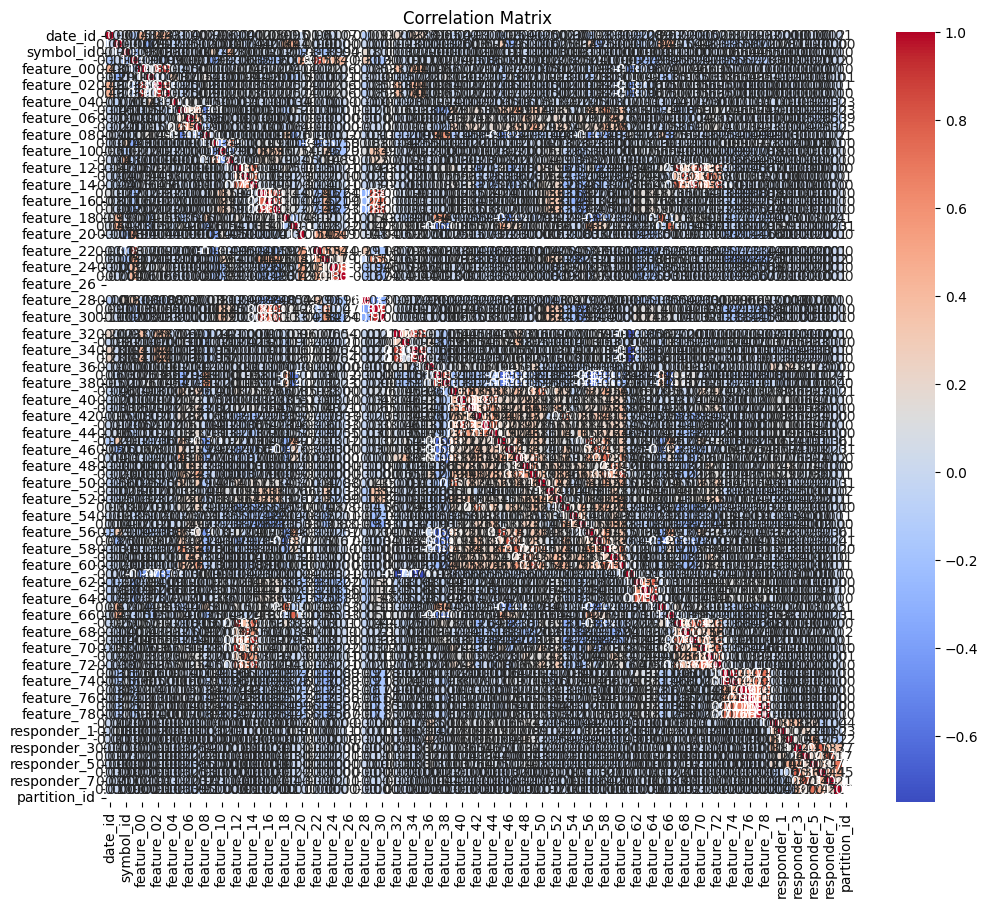

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()


In [22]:
# Get the correlation of all features with 'responder_1'
correlations_with_responder_1 = correlation_matrix["responder_6"].drop("responder_6")

# Sort correlations in descending order and get the top 10 features
top_10_features = correlations_with_responder_1.abs().sort_values(ascending=False).head(20)

# Display the result
print("Top 10 Features Correlated with Responder_6:")
print(top_10_features)


Top 10 Features Correlated with Responder_6:
feature_21           NaN
feature_26           NaN
feature_27           NaN
feature_31           NaN
partition_id         NaN
responder_3     0.784553
responder_8     0.447046
responder_7     0.439425
responder_4     0.361525
responder_5     0.339916
responder_0     0.099882
responder_1     0.057436
responder_2     0.052651
feature_06      0.050873
feature_56      0.032773
feature_07      0.032694
feature_04      0.032647
feature_45      0.028364
feature_05      0.021223
feature_57      0.021182
Name: responder_6, dtype: float64


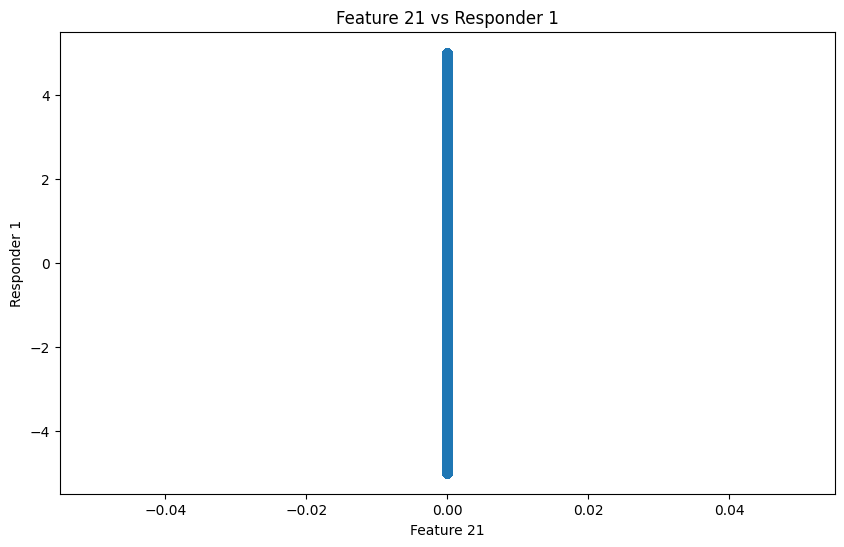

In [21]:
# Scatter plot for feature_21 vs responder_1
plt.figure(figsize=(10, 6))
plt.scatter(df['feature_21'], df['responder_1'], alpha=0.6)
plt.title('Feature 21 vs Responder 1')
plt.xlabel('Feature 21')
plt.ylabel('Responder 1')
plt.show()


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the features and target
features = ['responder_3', 'responder_4', 'responder_8', 'responder_7', 'responder_5']
target = 'responder_6'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# Display predictions vs actual values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head())


Model Coefficients: [ 0.8497443  -0.14142406  0.30783808  0.23925395 -0.28320453]
Model Intercept: 0.00039587077
Mean Squared Error (MSE): 0.267341285943985
R^2 Score: 0.697524070347366
           Actual  Predicted
2217279 -0.625125  -0.338824
1030393 -0.124242  -0.049329
897674   0.672475   0.386406
898751  -3.727389  -2.647138
1069276  0.230122   0.106650


### responder 6 plot

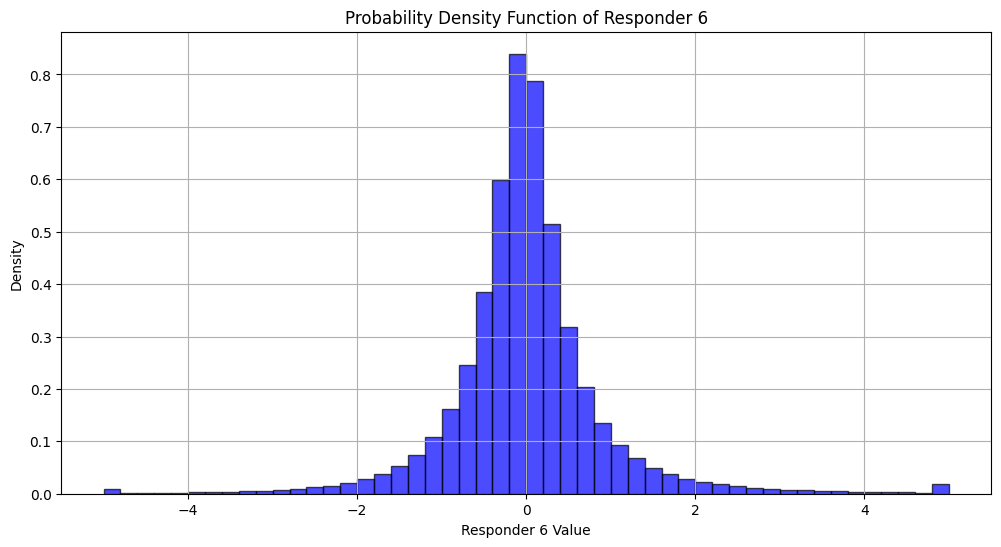

90% of the values of Responder 6 lie between -0.48766843676567073 and 0.43542302846908576.


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming df is your DataFrame containing responder_6
# Replace this with actual loading code if required
# df = pd.read_csv("your_data.csv")  # Example loading if not already loaded

# Extract responder_6 values
responder_6_values = df["responder_6"]

# Plot the PDF of responder_6 values
plt.figure(figsize=(12, 6))
plt.hist(responder_6_values, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title("Probability Density Function of Responder 6")
plt.xlabel("Responder 6 Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Calculate the range where 90% of values lie
lower_bound = np.percentile(responder_6_values, 20)
upper_bound = np.percentile(responder_6_values, 80)

print(f"90% of the values of Responder 6 lie between {lower_bound} and {upper_bound}.")


In [ ]:
95% of the values of Responder 6 lie between -1.4062880277633667 and 1.4500611066818234.
